In [30]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive display
from scipy.special import softmax
from abc import ABC, abstractmethod

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("../JC.mplstyle")


In [ ]:
class Strategy(ABC):
    def __init__(self, k_arm):
        self.k_arm = k_arm

    @abstractmethod
    def choose_action(self):
        pass

    @abstractmethod
    def update_q_est(self, action, reward, average_reward):
        pass

    def initialize(self):
        self.q_est = np.zeros(self.k_arm)
        self.action_count = np.zeros(self.k_arm)


In [ ]:
class EpsilonGreedyStrategy(Strategy):
    def __init__(self, k_arm, alpha, epsilon):
        super().__init__(k_arm)
        self.alpha = alpha
        self.epsilon = epsilon

    def choose_action(self, q_est):
        if np.random.random() < self.epsilon:
            action = np.random.randint(low=0, high=self.k_arm)
        else:
            action = np.random.choice(np.flatnonzero(q_est == q_est.max()))

        self.action_count[action] += 1
        return action

    def update_q_est(self, action, reward, average_reward):
        if self.alpha is None:
            self.q_est[action] += (reward - self.q_est[action]) / self.action_count[action]
        else:
            self.q_est[action] += (reward - self.q_est[action]) / self.action_count[action]



In [ ]:
class OptimisticStrategy(EpsilonGreedyStrategy):
    def __init__(self, k_arm, alpha, epsilon, initial_value):
        super().__init__(k_arm, alpha, epsilon)
        self.initial_value = initial_value

    def initialize(self):
        self.q_est = np.ones(self.k_arm)*self.initial_value
        self.action_count = np.zeros(self.k_arm)



In [ ]:
class GradientBanditStrategy(Strategy):
    def __init__(self, k_arm, alpha, baseline=True):
        super().__init__(k_arm)
        self.alpha = alpha
        self.baseline = baseline

    def choose_action(self, q_est):
        p_action = self.softmax(q_est)
        action = np.random.choice(np.arange(self.k_arm), p=p_action)
        self.action_count[action] += 1
        return action

    def update_q_est(self, action, reward, average_reward):
        temp = np.zeros(self.k_arm)
        temp[action] = 1
        p_action = softmax(self.q_est)
        if self.baseline is True:
            self.q_est += (reward - average_reward) * self.alpha * (temp - p_action)
        else:
            self.q_est += reward * self.alpha * (temp - p_action)


In [ ]:
class Bandit:
    def __init__(self, k_arm, time_steps, set_size, strategy):
        self.k_arm = k_arm
        self.time_steps = time_steps
        self.set_size = set_size
        self.average_reward = None
        self.optimal_action = None
        self.strategy = strategy

    def simulate(self):
        total_reward = []
        total_optimal = []

        for i_set in range(self.set_size):
            q = np.random.standard_normal(size=self.k_arm)
            reward_list = []
            optimal_list = []
            average_reward = 0
            self.strategy.initialize()

            for i_step in range(self.time_steps):
                q = self.update_true_values(q)
                optimal_action = np.argmax(q)

                action = self.strategy.choose_action()
                optimal_list.append(action == optimal_action)
                reward = np.random.normal(loc=q[action], scale=1)
                reward_list.append(reward)

                self.strategy.update_q_est(action, reward, average_reward)

            total_reward.append(reward_list)
            total_optimal.append(optimal_list)

        self.average_reward = np.array(total_reward).mean(axis=0)
        self.optimal_action = np.array(total_optimal).mean(axis=0)
    
    def update_true_values(self, q):
        return q
        
    def plot_strategy(self, ax):
        ax[0].plot(np.arange(self.time_steps), self.average_reward, linewidth=1)
        ax[0].set_ylabel('Average Reward')
        ax[0].set_xlabel("Steps")
        ax[1].plot(np.arange(self.time_steps), self.optimal_action, linewidth=1)
        ax[1].set_ylabel("Optimal Action (%)")
        ax[1].set_ylim([0, 1])
        ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax[1].set_xlabel("Steps")

6
4
0
6
2
2
5
4
5
1
5
9
4
6
9
3
5
8
9
7
0
9
4
0
3
1
0
1
6
4
6
3
1
7
7
0
4
8
3
8
1
2
2
6
5
7
7
7
1
3
2
6
0
5
9
2
9
3
8
5
9
2
3
7
9
9
0
1
6
5
2
4
6
0
4
6
3
8
0
7
1
6
1
8
7
9
8
2
7
4
4
2
1
6
4
7
1
2
7
9
8
0
9
2
6
2
8
6
9
9
7
2
1
5
6
7
0
0
6
6
0
4
6
9
3
9
7
3
3
3
7
6
1
4
2
7
1
9
5
5
2
2
0
8
9
2
1
2
9
1
1
0
4
1
3
4
0
3
2
9
4
8
4
4
6
3
0
1
6
9
1
3
1
8
7
1
5
7
1
8
1
3
8
7
5
2
8
0
6
8
6
8
0
2
5
0
3
7
9
4
7
4
2
6
1
1
1
7
2
2
1
0
6
1
1
4
4
8
4
6
6
5
3
6
2
0
8
3
0
5
4
0
9
4
7
9
0
5
0
2
0
0
9
0
4
6
5
1
1
5
0
8
1
6
9
7
2
0
9
1
7
7
2
4
2
7
1
6
5
1
7
2
1
9
0
1
1
8
0
2
5
5
0
6
6
6
2
7
3
3
4
0
2
8
5
9
4
6
3
2
2
6
6
6
6
0
7
5
3
4
5
9
2
1
6
9
2
2
0
4
3
0
9
9
0
4
2
3
0
5
3
4
4
3
4
8
2
7
4
5
6
6
4
1
3
7
2
5
1
1
1
1
3
6
4
3
5
1
5
9
5
9
0
9
8
2
3
8
3
5
5
5
4
9
0
9
6
5
2
7
3
1
6
0
7
5
4
1
6
9
2
2
7
5
9
5
3
7
5
8
0
2
4
8
7
1
8
7
2
2
4
0
4
7
7
3
4
0
8
2
6
4
4
7
1
3
0
8
8
8
3
3
9
1
5
7
9
3
4
1
3
6
7
4
4
3
4
3
7
4
9
6
3
6
8
8
1
3
8
2
2
8
0
9
5
4
3
3
1
3
8
8
6
5
2
6
4
7
4
7
2
2
5
2
8
0
1
0
2
5
2
6
8
7
8
3
0
5
8
4


KeyboardInterrupt: 

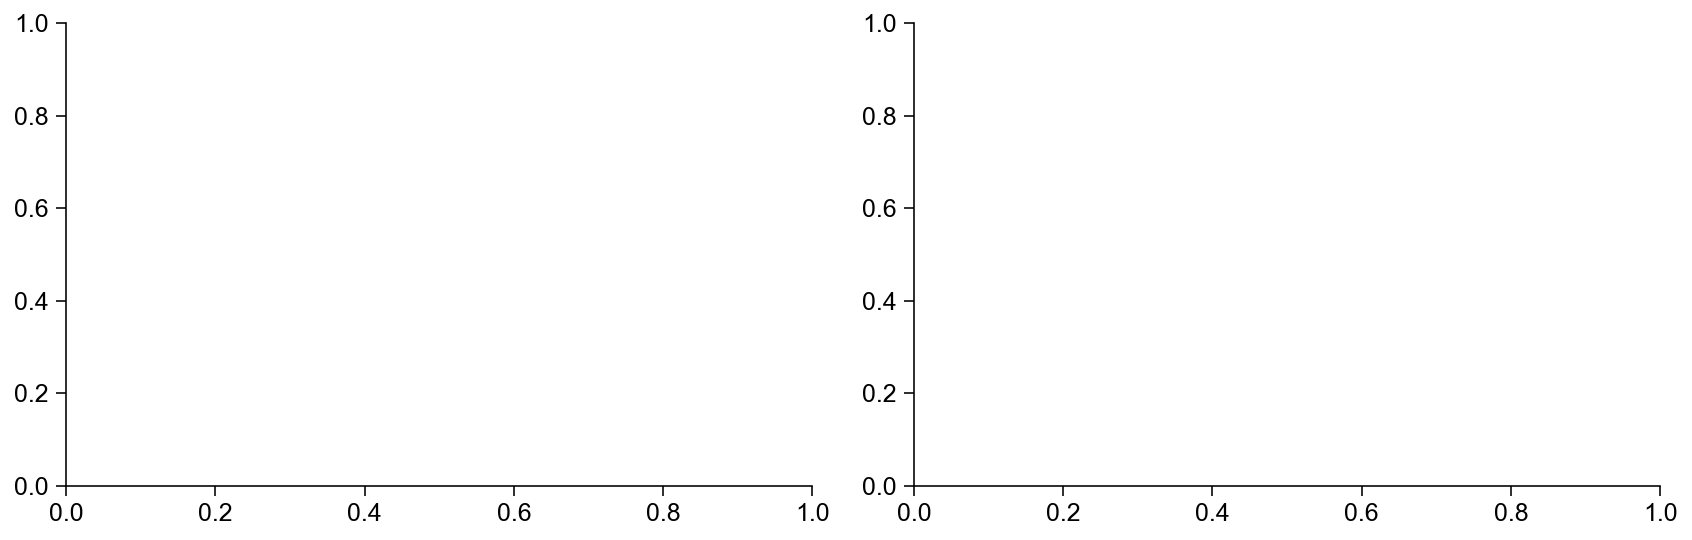

In [50]:
epsilon_list = [0.1,0.01,0]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for epsilon in epsilon_list:
    strategy = EpsilonGreedy(k_arm=10, epsilon=epsilon, alpha=None)
    bandit = Bandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy)
    bandit.simulate()
    bandit.plot_strategy(ax)
plt.legend([r'$\epsilon=0$', r'$\epsilon=0.01$', r'$\epsilon=0.1$'], bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

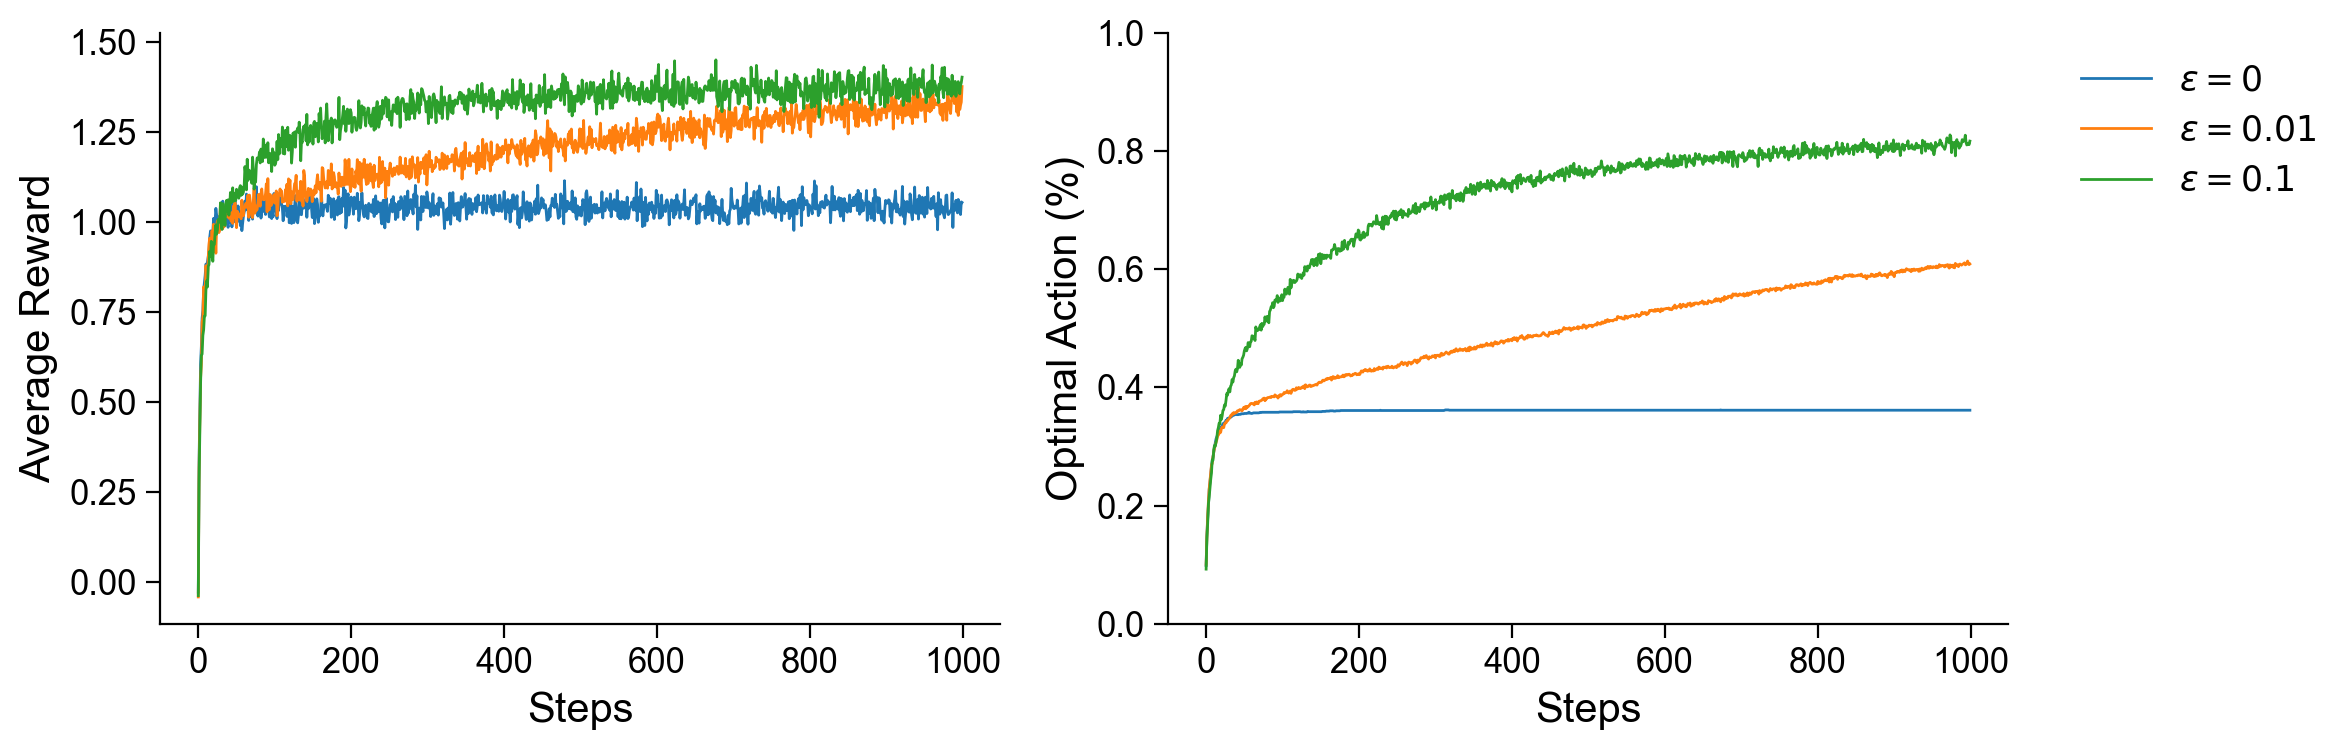

In [3]:
# 10-armed testbed
epsilon_list = [0, 0.01, 0.1]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for epsilon in epsilon_list:
    set_size =  2000
    k_arm = 10
    time_steps = 1000
    Total_reward = []
    Total_optimal = []
    for i_set in range(set_size):
        q = rng.standard_normal(size=k_arm)
        optimal_action = np.argmax(q)
        action_count = np.zeros(k_arm)
        q_est = np.zeros(k_arm)
        reward_list = []
        optimal_list = []
        for i_step in range(time_steps):
            
            if rng.random() < epsilon:
                action = rng.integers(low=0, high=k_arm)
                optimal_list.append(action==optimal_action)
            else:
                action = rng.choice(np.flatnonzero(q_est == q_est.max()))
                optimal_list.append(action==optimal_action)

            action_count[action] += 1
            reward = rng.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            q_est[action] += (reward - q_est[action])/action_count[action]
        
        
        Total_reward.append(reward_list)
        Total_optimal.append(optimal_list)
    Total_reward = np.array(Total_reward)
    Total_optimal = np.array(Total_optimal)
    Average_reward = np.mean(Total_reward,axis=0)
    Average_optimal = np.mean(Total_optimal,axis=0)
    plot_strategy(ax, time_steps, Average_reward, Average_optimal)

plt.legend([r'$\epsilon=0$',r'$\epsilon=0.01$',r'$\epsilon=0.1$'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()

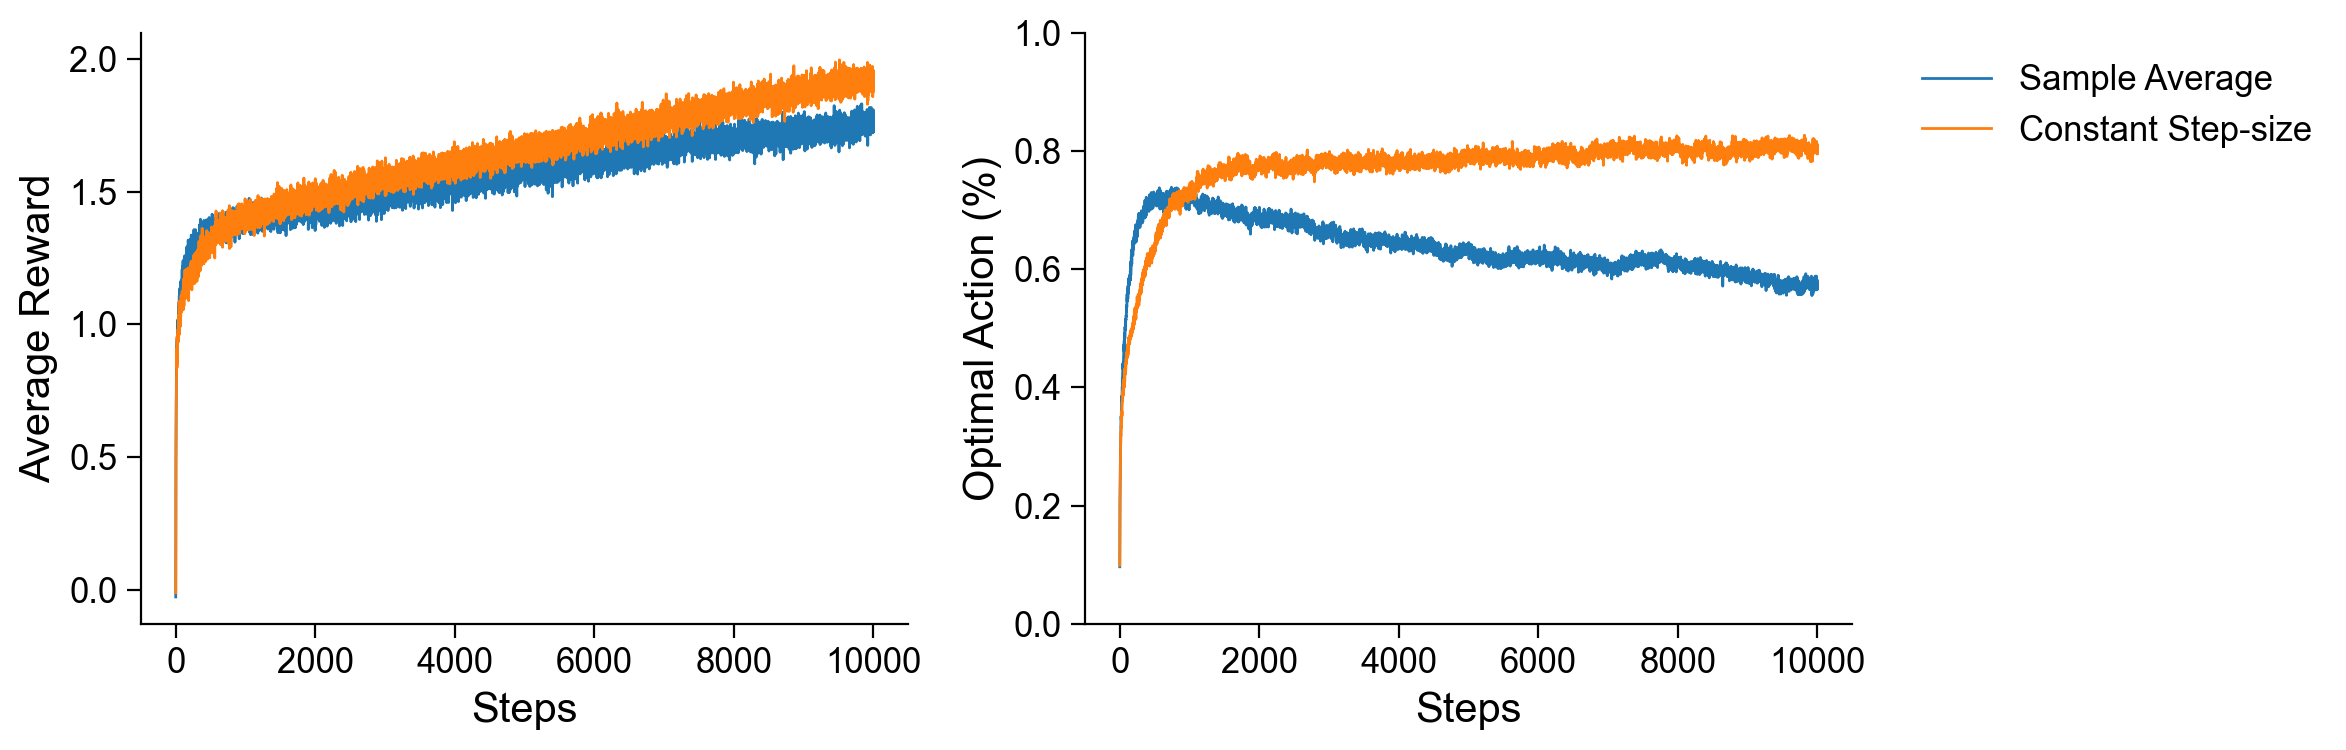

In [4]:
# a non-stationary problem
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for stategy in range(2):
    alpha = 0.1
    epsilon = 0.1
    set_size =  2000
    k_arm = 10
    time_steps = 10000
    Total_reward = []
    Total_optimal = []
    for i_set in range(set_size):
        q = rng.standard_normal(size=k_arm)
        action_count = np.zeros(k_arm)
        q_est = np.zeros(k_arm)
        reward_list = []
        optimal_list = []
        
        for i_step in range(time_steps):
            q += rng.normal(loc=0, scale=0.01, size=k_arm)
            optimal_action = np.argmax(q)

            if rng.random() < epsilon:
                action = rng.integers(low=0, high=k_arm)
                optimal_list.append(action==optimal_action)
            else:
                action = rng.choice(np.flatnonzero(q_est == q_est.max()))
                optimal_list.append(action==optimal_action)

            action_count[action] += 1
            reward = rng.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            if stategy == 0:
                q_est[action] += (reward - q_est[action])/action_count[action]
            else:
                q_est[action] += (reward - q_est[action])*alpha
            

        Total_reward.append(reward_list)
        Total_optimal.append(optimal_list)

            
    Total_reward = np.array(Total_reward)
    Total_optimal = np.array(Total_optimal)
    Average_reward = np.mean(Total_reward,axis=0)
    Average_optimal = np.mean(Total_optimal,axis=0)
    plot_strategy(ax, time_steps, Average_reward, Average_optimal)
    
plt.legend(["Sample Average", 'Constant Step-size'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()

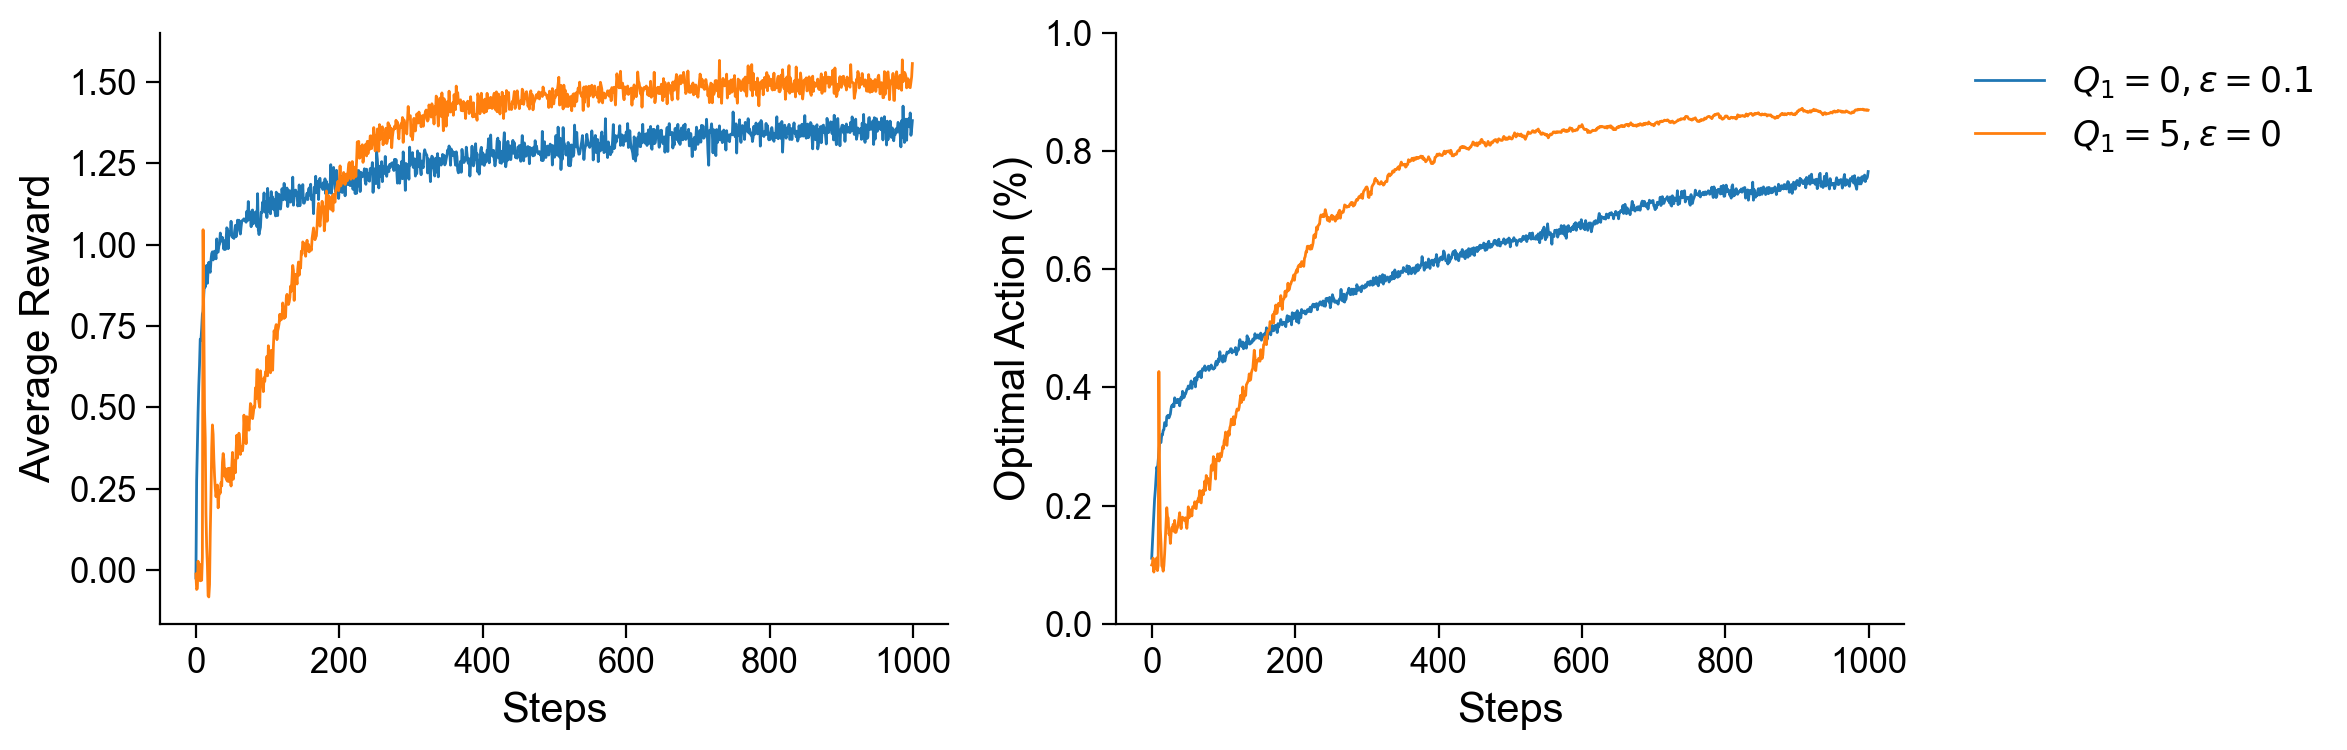

In [5]:
# Optimistic initial value
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for stategy in range(2):
    alpha = 0.1
    set_size =  2000
    k_arm = 10
    time_steps = 1000
    Total_reward = []
    Total_optimal = []
    for i_set in range(set_size):
        q = rng.standard_normal(size=k_arm)
        optimal_action = np.argmax(q)

        if stategy == 0:
            q_est = np.zeros(k_arm)
            epsilon = 0.1
        else:
            q_est = np.ones(k_arm)*5
            epsilon = 0
                
        reward_list = []
        optimal_list = []

        for i_step in range(time_steps):

            if rng.random() < epsilon:
                action = rng.integers(low=0, high=k_arm)
                optimal_list.append(action==optimal_action)
            else:
                action = rng.choice(np.flatnonzero(q_est == q_est.max()))
                optimal_list.append(action==optimal_action)

            reward = rng.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            
            q_est[action] += (reward - q_est[action])*alpha
            

        Total_reward.append(reward_list)
        Total_optimal.append(optimal_list)

            
    Total_reward = np.array(Total_reward)
    Total_optimal = np.array(Total_optimal)
    Average_reward = np.mean(Total_reward,axis=0)
    Average_optimal = np.mean(Total_optimal,axis=0)
    plot_strategy(ax, time_steps, Average_reward, Average_optimal)
    
plt.legend([r'$Q_{1}=0,\epsilon=0.1$', r'$Q_{1}=5,\epsilon=0$'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()

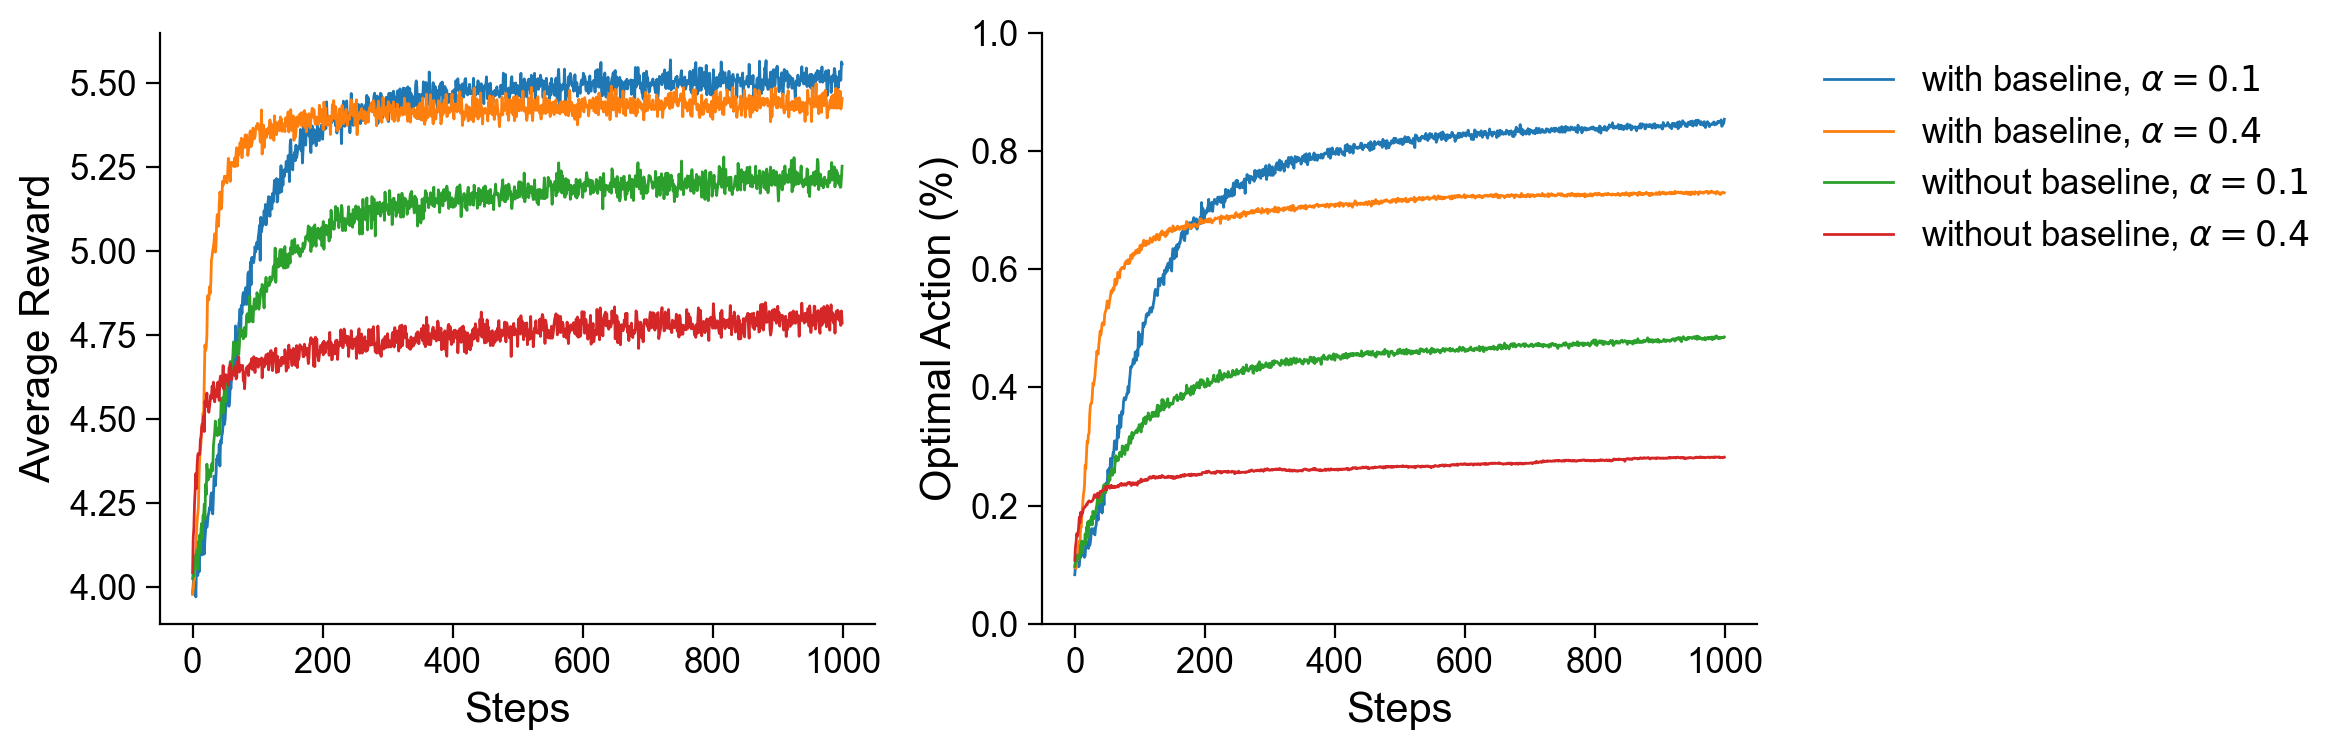

In [6]:
# Gradient Bandit Algorithm
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for stategy in range(4):
    if stategy == 0 or stategy == 2:
        alpha = 0.1
    else:
        alpha = 0.4

    set_size =  2000
    k_arm = 10
    time_steps = 1000
    Total_reward = []
    Total_optimal = []
    for i_set in range(set_size):
        q = rng.normal(loc=4, scale=1, size=k_arm)
        optimal_action = np.argmax(q)
        q_est = np.zeros(k_arm)
        
        reward_list = []
        optimal_list = []
        average_reward = 0
        for i_step in range(time_steps):
            p_action = softmax(q_est)
            action = rng.choice(np.arange(k_arm), p = p_action)
            optimal_list.append(action==optimal_action)

            reward = rng.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            if stategy == 0 or stategy == 1:
                average_reward += (reward - average_reward)/(i_step+1)
            temp = np.zeros(k_arm)
            temp[action] = 1
            q_est += (reward - average_reward)*alpha*(temp-p_action)
            

        Total_reward.append(reward_list)
        Total_optimal.append(optimal_list)

            
    Total_reward = np.array(Total_reward)
    Total_optimal = np.array(Total_optimal)
    Average_reward = np.mean(Total_reward,axis=0)
    Average_optimal = np.mean(Total_optimal,axis=0)
    plot_strategy(ax, time_steps, Average_reward, Average_optimal)
    
plt.legend([r'with baseline, $\alpha=0.1$', r'with baseline, $\alpha=0.4$', r'without baseline, $\alpha=0.1$', r'without baseline, $\alpha=0.4$'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()